In [20]:
# general imports
import os
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt 
import seaborn as sns

# from our documents
import OurFunctions as of

# from Scikit Learn library
from sklearn.model_selection import train_test_split, KFold, cross_val_score, GridSearchCV, ParameterGrid
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_curve, roc_auc_score, accuracy_score, make_scorer, precision_score, recall_score, f1_score, confusion_matrix
from sklearn.preprocessing import OneHotEncoder, RobustScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import LinearSVC
from sklearn.feature_selection import SelectKBest, f_classif, RFE
from sklearn.decomposition import PCA
from sklearn.neighbors import LocalOutlierFactor
from sklearn.tree import plot_tree 
from sklearn.calibration import CalibratedClassifierCV
import random

# from Imb Learn
from imblearn.over_sampling import SMOTENC, SMOTE

#seed for random processes
seed = 42
random.seed(seed)
np.random.seed(42)



We start importing our datasets, where ASD_phenotypic_original is the untouched dataset, ASD_phenotypic is the one proceding from the preprocessing and where the ASD_diagnosis dataset contains its respectives DX_GROUP.

In [21]:
ASD_phenotypic_original = pd.read_csv(os.path.join('DataSets','Phenotypic Datasets','ASD_phenotypic.csv'))
ASD_phenotypic = pd.read_csv(os.path.join('DataSets','Phenotypic Datasets','ASD_phenotypic_preprocessed.csv'))
ASD_diagnosis = pd.read_csv(os.path.join('DataSets','Phenotypic Datasets','ASD_clinical.csv'))

# Classification

First of all, we split the data into train set and test set, to be sure that our classifier is evaluated on data that it had never seen before.

In [22]:

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(ASD_phenotypic, ASD_diagnosis['DX_GROUP'], test_size=0.3, random_state=42)
print("Training set size:", X_train.shape)
print("Test set size:", X_test.shape)

Training set size: (213, 8)
Test set size: (92, 8)


We want to check the balance between classes for each set, to  be sure we are training the classifier using a good split.

In [23]:
class_counts_test = y_test.value_counts(normalize=True)
class_counts_train = y_train.value_counts(normalize=True)
class_count_train_num = y_train.value_counts()

# Print class count DX_GROUP
print("Class proportions for:")
print("- test set: " + str(class_counts_test))
print("- train set: " + str(class_counts_train))
print("Num subjects involved per "+ str(class_count_train_num))

Class proportions for:
- test set: DX_GROUP
1    0.728261
2    0.271739
Name: proportion, dtype: float64
- train set: DX_GROUP
1    0.760563
2    0.239437
Name: proportion, dtype: float64
Num subjects involved per DX_GROUP
1    162
2     51
Name: count, dtype: int64


In order to fix the umbalancing for the training phase, we use SMOTENC (variable of SMOTE that can handle categorical features), to create fictious subjects and rebalance them.

In [24]:
categorical_columns = X_train.select_dtypes(include=['object']).columns
categorical_features = categorical_columns.tolist()

# Initializing SMOTE-NC 
sampler = SMOTENC(categorical_features=categorical_features, random_state=42)

# Applying SMOTE-NC in order to generate new syntetic samples
X_SMOTE, Y_SMOTE = sampler.fit_resample(X_train, y_train)

# Print class distribution after SMOTE-NC application
print(pd.Series(Y_SMOTE).value_counts(normalize=True))
print("Num subjects involved per")
print(pd.Series(Y_SMOTE).value_counts())


DX_GROUP
1    0.5
2    0.5
Name: proportion, dtype: float64
Num subjects involved per
DX_GROUP
1    162
2    162
Name: count, dtype: int64


We can see that the dataset is unbalanced, having 60% of the subjects with autism condition. However, the split separates train and test sets respecting the proportion.

## General pipeline

The pipeline receive as mandatory arguments the dataset, the target and the chosen classifier, it also has some optional parameters that can specify some actions or parameters.

- To achieve a more reliable accuracy score we use k-fold cross validation. In this way we are performing the training on different train and validation fold and we avoid to have a better accuracy based only on the subjects we selected (k of cv can be set up from the outside).
- There exist the option to select if to use an encoder or a scaler (by default both options are set to true).
- The pipeline execute grid search to find the best hyperparameters per our training.
- The grid search can use both default parameters present in the function or gived by the useer as well.
- The algorithm can handle three different types of classifier: KNearestNeighbors, RandomForestClassifier and LinearSupportVectorMachine.
- The feature selection can be integrated to the pipeline if requested.

The output is composed by the trained model, the best_parameters found by the grid search, the best achieved accuracy, and if in case the feature_selector is activated, also the selected_features.


In [25]:
def general_pipeline(dataset, target, classifier, encoder = True, scaler = True, parameters_grid_search = None, cv = None, feature_selector=False,  parameters_feature_selector = None):

    # Defining metrics to be used as scoring 
    scoring = {
        'accuracy': make_scorer(accuracy_score),
        'precision': make_scorer(precision_score),
        'recall': make_scorer(recall_score),
        'f1_score': make_scorer(f1_score)
    }

    # Preprocess to make on the train data may include
    # - normalization of the numerical columns
    # - one hot encoding on the categorical columns
    
    categorical_columns = dataset.select_dtypes(include=['object']).columns

    if not encoder: #only scaler
        transformers = [('num', RobustScaler(), ~dataset.columns.isin(categorical_columns))]
    elif not scaler: #only encoder
        transformers = [('cat', OneHotEncoder(handle_unknown='ignore'), categorical_columns)]
    elif not encoder and not scaler:
        transformers = []
    else: # both scaler and encoder
        transformers=[
            ('num', RobustScaler(), ~dataset.columns.isin(categorical_columns)),
            ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_columns),
        ]

    preprocessor = ColumnTransformer(transformers=transformers)

    # set parameters per KNN case
    if isinstance(classifier, KNeighborsClassifier):
        parameter_type = 'classifier__n_neighbors'
        if parameters_grid_search:
            parameters = {parameter_type: parameters_grid_search}  # n_neighbors values to be explored 
        else:
            parameters = {parameter_type: [3, 5, 7, 9, 11]} 

        feature_selector_type = SelectKBest(score_func=f_classif)
        selector_parameter = 'feature_selection__k'
        
    # set parameters per RF case
    if isinstance(classifier, RandomForestClassifier):
        parameter_type = 'classifier__n_estimators'
        if parameters_grid_search:
            parameters = {parameter_type: parameters_grid_search}  
        else:
            parameters = {parameter_type: [10, 50, 200, 500, 1000]} 

        feature_selector_type = RFE(estimator=classifier)
        selector_parameter = 'feature_selection__n_features_to_select'

    # set parameters per LinearSVC case
    if isinstance(classifier, CalibratedClassifierCV):
        parameter_type = 'classifier__estimator__C'
        if parameters_grid_search:
            parameters = {parameter_type: parameters_grid_search}  
        else:
            parameters = {parameter_type: [0.001, 0.01, 0.1, 1, 10, 100]}  

        feature_selector_type = RFE(estimator=LinearSVC(dual=False, random_state=42))
        selector_parameter = 'feature_selection__n_features_to_select'

    
    if feature_selector: # in case feature selection is required
        
        sample_transformed = preprocessor.fit_transform(dataset)
        n_total_features = sample_transformed.shape[1]
        print("Total quantity of features after one hot encoding :" + str(n_total_features))
        
        # Pipeline with feature selector
        pipeline = Pipeline([
        ('preprocessor', preprocessor),
        ('feature_selection', feature_selector_type),
        ('classifier', classifier)  
        ])
        if parameters_feature_selector:
            parameters.update({selector_parameter: parameters_feature_selector})
        else: 
            parameters.update({selector_parameter: list(range(1, n_total_features+1))})
            
    else:
        # Pipeline without feature selector
        pipeline = Pipeline([
            ('preprocessor', preprocessor),
            ('classifier', classifier),
            ])

    # allows to change k of cross validation from the outside
    if cv:
        k_folds = cv
    else:
        k_folds = 5

    # Creating GridSearchCV
    grid_search = GridSearchCV(pipeline, parameters, cv= k_folds, scoring=scoring, refit='accuracy')

    # Executing 
    grid_search.fit(dataset, target)

    # Extraction of results

    means_accuracy = grid_search.cv_results_['mean_test_accuracy']
    stds_accuracy = grid_search.cv_results_['std_test_accuracy']
    means_precision = grid_search.cv_results_['mean_test_precision']
    means_recall = grid_search.cv_results_['mean_test_recall']
    means_f1_score = grid_search.cv_results_['mean_test_f1_score']
    params = grid_search.cv_results_['params']

    best_model = grid_search.best_estimator_
    best_parameter = [grid_search.best_params_[parameter_type]]
    best_accuracy = grid_search.best_score_
    best_f1_score = grid_search.cv_results_['mean_test_f1_score'][grid_search.best_index_]
    best_scores = [best_accuracy, best_f1_score]

    feature_names = []
    for feature in best_model.named_steps['preprocessor'].get_feature_names_out():
        feature_names.append(feature)
    # Visualization of results

    if not parameters_grid_search: #the parameter is not choose from the outside
        print("Cross-validation results for each combination of hyperparameters:")
        for mean_acc, std_acc, mean_prec, mean_rec, mean_f1, params in zip(means_accuracy, stds_accuracy, means_precision, means_recall, means_f1_score, params):
            print(f"Parameters: {params}, Accuracy: {mean_acc:.3f} (±{std_acc:.3f}), Precision: {mean_prec:.3f}, Recall: {mean_rec:.3f}, F1-score: {mean_f1:.3f}")

        print("\nBest parameter founded:")
        print(best_parameter)
        print("\nThe scores achieved are:")

    print("Accuracy:", best_accuracy)
    print("F1-score:", best_f1_score)

    if feature_selector:
        # Get the support mask and selected feature names from the preprocessed data
        feature_names = best_model.named_steps['preprocessor'].get_feature_names_out()
        selected_mask = best_model.named_steps['feature_selection'].get_support()
        selected_features = []
        for feature in feature_names[selected_mask]:
            selected_features.append(feature)

        print("\nSelected features are:")
        print(f"Number of selected features: {len(selected_features)}")
        print("Selected features:", selected_features)

        non_selected_mask = ~selected_mask
        non_selected_features = feature_names[non_selected_mask]

        print("\nNon selected features are:")
        print(f"Number of non selected features: {len(non_selected_features)}")
        print("Selected features:", non_selected_features)

        best_parameter.append(grid_search.best_params_[selector_parameter])

        return best_model, best_parameter, best_scores, selected_features
        
    return best_model, best_parameter, best_scores, feature_names
    

## General classifiers

We start training our classifiers with the default values, so we can find the most accurate parameters for the training.

### K-NEAREST NEIGHBOOR

To use the K-Nearest Neighbors, we need only numerical features, so we will use one-hot-encoding to turn the categorical features (which aren't ordinal) into numerical features. We also need to perform normalization, as we are using distancies to classify instancies.

In [26]:
classifier = KNeighborsClassifier()
knn_model, knn_parameter, knn_scores, _= general_pipeline(X_SMOTE, Y_SMOTE, classifier)


Cross-validation results for each combination of hyperparameters:
Parameters: {'classifier__n_neighbors': 3}, Accuracy: 0.923 (±0.029), Precision: 0.987, Recall: 0.858, F1-score: 0.916
Parameters: {'classifier__n_neighbors': 5}, Accuracy: 0.907 (±0.039), Precision: 0.993, Recall: 0.820, F1-score: 0.897
Parameters: {'classifier__n_neighbors': 7}, Accuracy: 0.907 (±0.034), Precision: 1.000, Recall: 0.814, F1-score: 0.896
Parameters: {'classifier__n_neighbors': 9}, Accuracy: 0.901 (±0.033), Precision: 0.993, Recall: 0.808, F1-score: 0.889
Parameters: {'classifier__n_neighbors': 11}, Accuracy: 0.898 (±0.036), Precision: 1.000, Recall: 0.795, F1-score: 0.884

Best parameter founded:
[3]

The scores achieved are:
Accuracy: 0.9228365384615385
F1-score: 0.9160577453719814


As we seen, we found that the best accuracy of the model is achieved using k = 3 and we obtained accuracy = 0.910 and F1-score = 0.904.

Now we test the algorithm on unseen data.

In [27]:
# Model evaluation on test data 
y_pred = knn_model.predict(X_test)

# Prints and stores scores of the model on testing set
accuracy, precision, recall, f1 = of.evaluation_test_scores(y_test, y_pred)


Model Evaluation on Test Data:
Accuracy: 0.880
Precision: 0.967
Recall: 0.866
F1-score: 0.913


We can see that the accuracy and the F1-score are both lower. Rispectively 0.85 (vs 0.911) and 0.889 (vs 0.904). 

To have a better idea of the performance, we display also the confusion matrix.

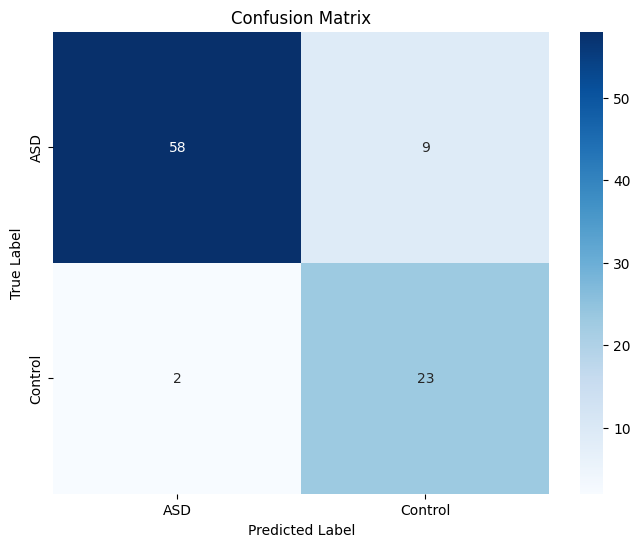

In [28]:
# Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, cmap="Blues", fmt="d", xticklabels=['ASD', 'Control'], yticklabels=['ASD', 'Control'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()


We can observe that in general we have a good fit, but there are 14 persons that are misclassified. In particular, there are 11 autistics that are classified as controls.

### Random Forest

To use the Random Forest classifier, I need to have only numerical features, so we will use one-hot-encoding to turn the categorical features (which aren't ordinal) into numerical features. It's not necessary to perform any normalization, but as we want to compare the performance of this classifier with others that use normalization, we will also use normalized data to train this classifier (it's not harmfull for the Random Forest Classifier).

In [29]:
classifier = RandomForestClassifier(random_state=42)
rf_model, rf_parameter, rf_scores, rf_features_names = general_pipeline(X_SMOTE, Y_SMOTE, classifier)

Cross-validation results for each combination of hyperparameters:
Parameters: {'classifier__n_estimators': 10}, Accuracy: 0.975 (±0.013), Precision: 0.988, Recall: 0.963, F1-score: 0.975
Parameters: {'classifier__n_estimators': 50}, Accuracy: 0.981 (±0.015), Precision: 0.994, Recall: 0.969, F1-score: 0.981
Parameters: {'classifier__n_estimators': 200}, Accuracy: 0.978 (±0.013), Precision: 0.994, Recall: 0.963, F1-score: 0.978
Parameters: {'classifier__n_estimators': 500}, Accuracy: 0.975 (±0.013), Precision: 0.994, Recall: 0.956, F1-score: 0.974
Parameters: {'classifier__n_estimators': 1000}, Accuracy: 0.978 (±0.016), Precision: 1.000, Recall: 0.956, F1-score: 0.977

Best parameter founded:
[50]

The scores achieved are:
Accuracy: 0.9813942307692308
F1-score: 0.9809273335478375


We found that the best accuracy, using 50 trees, is 0.985, and equal to the best F1-score.

In [30]:
# Evaluation Model on Test Data 
y_pred = rf_model.predict(X_test)

# Prints and stores scores of the model on testing set
accuracy, precision, recall, f1 = of.evaluation_test_scores(y_test, y_pred)




Model Evaluation on Test Data:
Accuracy: 0.967
Precision: 0.985
Recall: 0.970
F1-score: 0.977


The accuracy is 0.978 (vs 0.984), while the F1 score to 0.985 (vs 0.984), both are good results

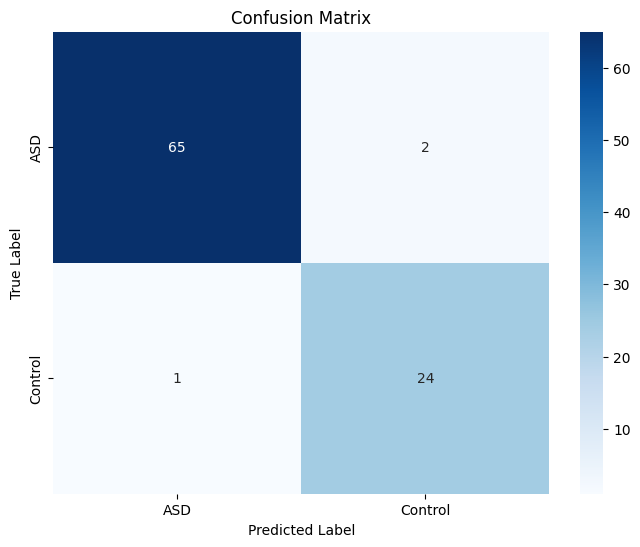

In [31]:
conf_matrix = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, cmap="Blues", fmt="d", xticklabels=['ASD', 'Control'], yticklabels=['ASD', 'Control'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()


Accordly to what we said before, there is an higher accuracy in the model, so we have a better fit of the model to the labeled data, with only 2 autistics misclassified.

### Support vector machine

We still using the default parameters and both encoding and scaler.

 Note: we use the calibrated classifier cv on the LinearSVC to enable the possibility to compute the ROC.

In [32]:
classifier = CalibratedClassifierCV(LinearSVC(dual=False, random_state=42))
svc_model, svc_parameter, svc_scores, _ = general_pipeline(X_SMOTE, Y_SMOTE, classifier)

Cross-validation results for each combination of hyperparameters:
Parameters: {'classifier__estimator__C': 0.001}, Accuracy: 0.929 (±0.029), Precision: 0.981, Recall: 0.876, F1-score: 0.923
Parameters: {'classifier__estimator__C': 0.01}, Accuracy: 0.941 (±0.023), Precision: 1.000, Recall: 0.882, F1-score: 0.937
Parameters: {'classifier__estimator__C': 0.1}, Accuracy: 0.951 (±0.012), Precision: 0.994, Recall: 0.907, F1-score: 0.948
Parameters: {'classifier__estimator__C': 1}, Accuracy: 0.954 (±0.014), Precision: 0.988, Recall: 0.920, F1-score: 0.952
Parameters: {'classifier__estimator__C': 10}, Accuracy: 0.954 (±0.014), Precision: 0.988, Recall: 0.920, F1-score: 0.952
Parameters: {'classifier__estimator__C': 100}, Accuracy: 0.954 (±0.014), Precision: 0.988, Recall: 0.920, F1-score: 0.952

Best parameter founded:
[1]

The scores achieved are:
Accuracy: 0.9536538461538463
F1-score: 0.9520077760684582


The best accuracy encountered is 0.951 and F1-score is 0.949.

Now we check on the test.

In [33]:
# Model evaluation on test data
y_pred = svc_model.predict(X_test)

# Prints and stores scores of the model on testing set
accuracy, precision, recall, f1 = of.evaluation_test_scores(y_test, y_pred)



Model Evaluation on Test Data:
Accuracy: 0.946
Precision: 1.000
Recall: 0.925
F1-score: 0.961


Also in this case there is a decrease of accuracy using test data, going to 0.935 (vs 0.951), and F1-score going to 0.961 (vs 0.952).

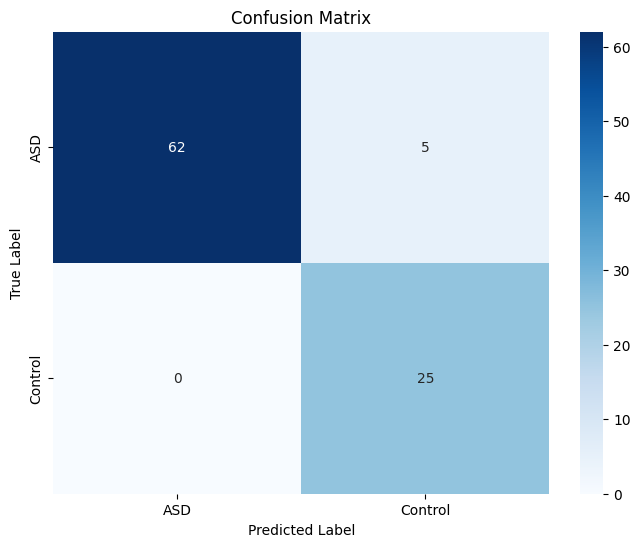

In [34]:
conf_matrix = confusion_matrix(y_test, y_pred)

# Visualizzazione della matrice di confusione
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, cmap="Blues", fmt="d", xticklabels=['ASD', 'Control'], yticklabels=['ASD', 'Control'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()


As we can see, this algorithm has a worst performance than RFC, but better than KNN, misclassifing 5 autistics as control. 

## Comparison Between Classifiers

To better compare the classifiers we evaluate the area under the ROC curve per each classifier.

In [35]:
# Function to evaluate the AUC-ROC for a given model based on the predicted probabilities
def evaluate_roc_auc(model, X_test, y_test):
    y_proba = model.predict_proba(X_test)[:, 1]
    auc_roc = roc_auc_score(y_test, y_proba)
    return auc_roc

knn_auc_roc = evaluate_roc_auc(knn_model, X_test, y_test)
rf_auc_roc = evaluate_roc_auc(rf_model, X_test, y_test)
svc_auc_roc = evaluate_roc_auc(svc_model, X_test, y_test)

# Print the results
print("K-Nearest Neighbors Classifier AUC-ROC:", knn_auc_roc)
print("Random Forest Classifier AUC-ROC:", rf_auc_roc)
print("Support vector Classifier AUC-ROC:", svc_auc_roc)


K-Nearest Neighbors Classifier AUC-ROC: 0.9304477611940298
Random Forest Classifier AUC-ROC: 0.9800000000000001
Support vector Classifier AUC-ROC: 0.9713432835820895


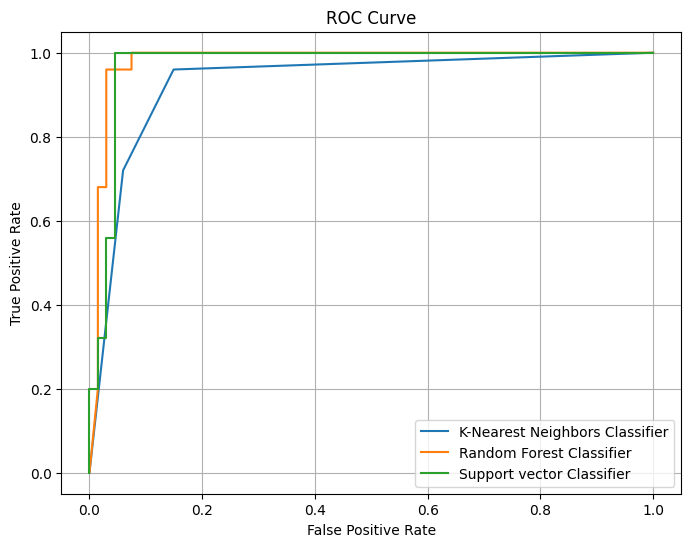

In [36]:
# Function to plot the ROC curve for a given model
def plot_roc_curve(model, X_test, y_test, model_name):
    y_proba = model.predict_proba(X_test)[:, 1]
    fpr, tpr, _ = roc_curve(y_test, y_proba)
    plt.plot(fpr, tpr, label=model_name)
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.legend()
    plt.grid(True)

# We need to make the diagnostic binary (instead of 1 and 2)
y_test_binary = (y_test == 2).astype(int)

plt.figure(figsize=(8, 6))
plot_roc_curve(knn_model, X_test, y_test_binary, 'K-Nearest Neighbors Classifier')
plot_roc_curve(rf_model, X_test, y_test_binary, 'Random Forest Classifier')
plot_roc_curve(svc_model, X_test, y_test_binary, 'Support vector Classifier')
plt.show()


We know that that the curve that gets more closer to one in the True Positive Rate is the one with the best performance. As we predicted before, the more accurate classifier for this problem is the RF (0.983 of auc score), followed by the SVC (0.973 of auc score) and finally by the KNN (0.954 of auc score).

# Outlier Detection

Now we want to check if the possible presence of outlier that we checked  during the exploration is really affecting the performance of our classifiers.

The following function uses Local Outlier Factor to determine if a subject can be considered as outlier or not, the contamination_factor is set by a grid search. It returns the datasets without outliers subjects.

In [37]:
def outlier_detector(dataset, diagnosis, contamination_factor, k_neighbors):
    dataset_outliers = dataset.select_dtypes(include=[np.number])
    X = dataset_outliers.values

    # Initialize Local Outlier Factor
    lof = LocalOutlierFactor(n_neighbors=k_neighbors, contamination=contamination_factor)  # Adjust parameters as needed
    '''n_neighbors | if too small: model sensible to noise and random outliers
                     if too large: diculties in local outliers detection, in particular if in absence of a uniform distribution
       contamination | data portion expected as outliers'''
    
    # Fit the model and predict outliers
    outliers = lof.fit_predict(X)

    # Print number of detected outliers
    print(f"___________________\nNumber of outliers detected: {np.sum(outliers == -1)}")

    # outliers == -1 indicates outliers, 1 indicates inliers
    dataset_outliers['outlier'] = outliers

    outlier_subjects = dataset_outliers[dataset_outliers['outlier'] == -1]

    pd.set_option('display.max_columns', None); outlier_subjects.T

    # Stores the datasets without outliers
    
    dataset_without_outliers = dataset[dataset_outliers['outlier'] == 1]
         
    diagnosis_without_outliers = diagnosis[dataset_outliers['outlier'] == 1]

    return dataset_without_outliers, diagnosis_without_outliers, lof

We implement the grid search to find the best contamination factor for each one of the classifiers and we check their performances.

In [38]:


# Initialized dictionaries to store best accuracy, best models, best parameters, contamination, and k_neighbors for each classifier.
best_accuracies = {KNeighborsClassifier: 0, RandomForestClassifier: 0, CalibratedClassifierCV: 0}
best_f1_scores = {KNeighborsClassifier: 0, RandomForestClassifier: 0, CalibratedClassifierCV: 0}
best_models = {KNeighborsClassifier: 0, RandomForestClassifier: 0, CalibratedClassifierCV: 0}
best_parameters = {KNeighborsClassifier: 0, RandomForestClassifier: 0, CalibratedClassifierCV: 0}
best_contaminations = {KNeighborsClassifier: None, RandomForestClassifier: None, CalibratedClassifierCV: None}
best_k_neighbors = {KNeighborsClassifier: None, RandomForestClassifier: None, CalibratedClassifierCV: None}

# Initialized variables to store the best overall accuracy, f1-score, corresponding classifier, contamination factor, and k_neighbors.
best_overall_accuracy = 0
best_overall_f1_score = 0
best_overall_classifier = None
best_overall_contamination = None
best_overall_k_neighbors = None

# Define the parameter grid
param_grid = {
    'contamination_factor': [0.0033, 0.0098, 0.0230, 0.0361, 0.05, 0.081],
    'k_neighbors': [2, 3, 5, 10, 20]
}

# Generate all combinations of parameters
grid = ParameterGrid(param_grid)

# Iterate over all parameter combinations
for params in grid:
    contamination_factor = params['contamination_factor']
    k_neighbors = params['k_neighbors']

    ASD_phenotypic_without_outliers, ASD_diagnosis_without_outliers, _ = outlier_detector(ASD_phenotypic, ASD_diagnosis, contamination_factor, k_neighbors)

    X_train_od, X_test_od, y_train_od, y_test_od = train_test_split(ASD_phenotypic_without_outliers, ASD_diagnosis_without_outliers['DX_GROUP'], test_size=0.3, random_state=42)

    categorical_columns = X_train_od.select_dtypes(include=['object']).columns
    categorical_features = categorical_columns.tolist()

    # Initialize the SMOTE-NC object
    sampler = SMOTENC(categorical_features=categorical_features, random_state=42)
    X_SMOTE_od, Y_SMOTE_od = sampler.fit_resample(X_train_od, y_train_od)

    classifiers = [KNeighborsClassifier(), RandomForestClassifier(random_state=42), CalibratedClassifierCV(LinearSVC(dual=False, random_state=42))]
    
    for classifier in classifiers:
        print(f"\n_____\nEvaluating classifier: {type(classifier).__name__}")
        print(f"with contamination factor = {contamination_factor} and k_neighbors = {k_neighbors}")
        
        model, parameters, scores, _ = general_pipeline(X_SMOTE_od, Y_SMOTE_od, classifier)
        
        # Update best accuracy and contamination for the specific classifier
        classifier_type = type(classifier)

        if scores[0] > best_accuracies[classifier_type]:
            best_accuracies[classifier_type] = scores[0]
            best_f1_scores[classifier_type] = scores[1]
            best_parameters[classifier_type] = parameters
            best_contaminations[classifier_type] = contamination_factor
            best_k_neighbors[classifier_type] = k_neighbors
            best_models[classifier_type] = model
        
        # Update best overall accuracy and corresponding classifier, contamination, and k_neighbors
        if scores[0] > best_overall_accuracy:
            best_overall_accuracy = scores[0]
            best_overall_f1_score = scores[1]
            best_overall_classifier = classifier_type
            best_overall_contamination = contamination_factor
            best_overall_k_neighbors = k_neighbors


___________________
Number of outliers detected: 2

_____
Evaluating classifier: KNeighborsClassifier
with contamination factor = 0.0033 and k_neighbors = 2
Cross-validation results for each combination of hyperparameters:
Parameters: {'classifier__n_neighbors': 3}, Accuracy: 0.929 (±0.016), Precision: 0.982, Recall: 0.876, F1-score: 0.924
Parameters: {'classifier__n_neighbors': 5}, Accuracy: 0.922 (±0.014), Precision: 0.993, Recall: 0.851, F1-score: 0.916
Parameters: {'classifier__n_neighbors': 7}, Accuracy: 0.919 (±0.011), Precision: 0.982, Recall: 0.857, F1-score: 0.914
Parameters: {'classifier__n_neighbors': 9}, Accuracy: 0.910 (±0.015), Precision: 0.988, Recall: 0.833, F1-score: 0.902
Parameters: {'classifier__n_neighbors': 11}, Accuracy: 0.907 (±0.026), Precision: 0.993, Recall: 0.820, F1-score: 0.897

Best parameter founded:
[3]

The scores achieved are:
Accuracy: 0.9286057692307693
F1-score: 0.9243628879129162

_____
Evaluating classifier: RandomForestClassifier
with contaminat

KeyboardInterrupt: 

Then we print the best results:

In [ ]:
# Print the best results for each classifier
for classifier_type in best_accuracies:
    print(f"\n{classifier_type.__name__} with best parameter = {best_parameters[classifier_type]}")
    print(f"Best contamination factor: {best_contaminations[classifier_type]} with k_neighbors: {best_k_neighbors[classifier_type]}")
    print(f"Achieved Accuracy : {best_accuracies[classifier_type]}, F1_score: {best_f1_scores[classifier_type]}")

# Print the best overall result
print(f"\nBest overall contamination factor: {best_overall_contamination} with k_neighbors: {best_overall_k_neighbors} for classifier: {best_overall_classifier.__name__}")



KNeighborsClassifier with best parameter = [3]
Best contamination factor: 0.0098 with k_neighbors: 5
Achieved Accuracy : 0.947451923076923, F1_score: 0.9436897713752396

RandomForestClassifier with best parameter = [50]
Best contamination factor: 0.0361 with k_neighbors: 3
Achieved Accuracy : 0.993599590373784, F1_score: 0.9935467083008067

CalibratedClassifierCV with best parameter = [0.1]
Best contamination factor: 0.0361 with k_neighbors: 10
Achieved Accuracy : 0.964516129032258, F1_score: 0.9628133613104535

Best overall contamination factor: 0.0361 with k_neighbors: 3 for classifier: RandomForestClassifier


We found the following outcomes for the training:
- Best contamination factor for KNeighborsClassifier: 0.0361 with accuracy: 0.942 and f1_score: 0.935
- Best contamination factor for RandomForestClassifier: 0.0361 with accuracy: 0.994 and f1_score: 0.993
- Best contamination factor for CalibratedClassifierCV: 0.0361 with accuracy: 0.968 and f1_score: 0.966

Highlighting that RandomForestClassifier is one more time the most accurate.

To have a visual idea of the eliminated outliers, we perfomed a PCA transformation of the space to 2 dimensions for 0.0361 contamination factor and 3 k neighbors.

___________________
Number of outliers detected: 11


C:\Users\auran\AppData\Local\Temp\ipykernel_12264\4063459032.py:19: UserWarning: You passed a edgecolor/edgecolors ('k') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  plt.scatter(outliers[:, 0], outliers[:, 1], c='blue', edgecolor='k', marker='x', s=100, label='Outliers')  # Highlight outliers


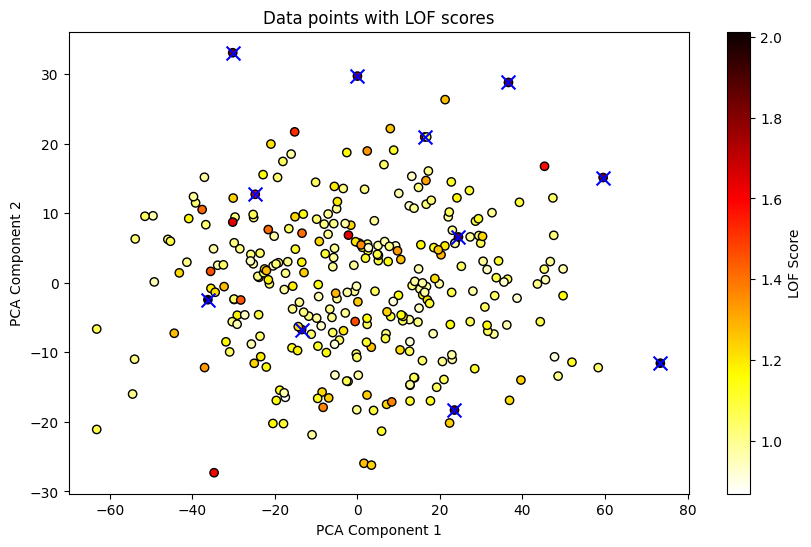

In [ ]:
ASD_phenotypic_without_outliers, ASD_diagnosis_without_outliers, lof = outlier_detector(ASD_phenotypic, ASD_diagnosis, best_overall_contamination, best_overall_k_neighbors)
X_train_od, X_test_od, y_train_od, y_test_od = train_test_split(ASD_phenotypic_without_outliers, ASD_diagnosis_without_outliers['DX_GROUP'], test_size=0.3, random_state=42)

num_features = ASD_phenotypic.select_dtypes(np.number)
X = num_features.values
# Perform PCA for dimensionality reduction
pca = PCA(n_components=2)
X_reduced = pca.fit_transform(X)
outliers = X_reduced[ASD_phenotypic_without_outliers.index]
outlier_indices = ASD_phenotypic.index.difference(ASD_phenotypic_without_outliers.index)
outliers = X_reduced[outlier_indices]

lof_scores = lof.negative_outlier_factor_

# Plot the data points with color indicating LOF scores
plt.figure(figsize=(10, 6))
plt.scatter(X_reduced[:, 0], X_reduced[:, 1], c=-lof_scores, cmap='hot_r', edgecolor='k', label='Inliers')
plt.colorbar(label='LOF Score')
plt.scatter(outliers[:, 0], outliers[:, 1], c='blue', edgecolor='k', marker='x', s=100, label='Outliers')  # Highlight outliers
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.title('Data points with LOF scores')
plt.show()

We can see that the dots with higher LOF scores were eliminated. Some of them are placed peripherical, but others are in a dense region (this could happen due to the 2d transformation.)

Then we check the accuracies on the test sets.

### K-NEAREST NEIGHBORS

In [ ]:
# Valutazione del modello sui dati di test
model = best_models[type(KNeighborsClassifier())]
y_pred = model.predict(X_test_od)

# Prints and stores scores of the model on testing set
accuracy, precision, recall, f1 = of.evaluation_test_scores(y_test_od, y_pred)



Model Evaluation on Test Data:
Accuracy: 0.876
Precision: 0.966
Recall: 0.862
F1-score: 0.911


The parameter selected per k is 3.

Previous results were:
- Accuracy with outliers - 0.88
- F1-score with outliers - 0.912

And now we have:
- Accuracy without outliers - 0.809
- F1-score without outliers - 0.862

So it seems that the elimination of the outliers is not benefitial for the classificator.

### RANDOM FOREST CLASSIFIER

In [ ]:
# Valutazione del modello sui dati di test
model = best_models[type(RandomForestClassifier(random_state=42))]
y_pred = model.predict(X_test_od)

# Prints and stores scores of the model on testing set
accuracy, precision, recall, f1 = of.evaluation_test_scores(y_test_od, y_pred)



Model Evaluation on Test Data:
Accuracy: 0.910
Precision: 0.983
Recall: 0.892
F1-score: 0.935


The parameter selected for the amount of trees is 50.

Previous results were:
- Accuracy with outliers - 0.978
- F1-score with outliers - 0.985

And now we have:
- Accuracy without outliers - 0.888
- F1-score without outliers - 0.921

We can see that the accuracy and f1-score are lower, so maybe is better to work in the dataset without outlier detection.

### SUPPORT VECTOR MACHINE

In [ ]:
# Valutazione del modello sui dati di test
model = best_models[type(CalibratedClassifierCV(LinearSVC(dual=False, random_state=42)))]
y_pred = model.predict(X_test_od)

# Prints and stores scores of the model on testing set
accuracy, precision, recall, f1 = of.evaluation_test_scores(y_test_od, y_pred)


Model Evaluation on Test Data:
Accuracy: 0.865
Precision: 0.982
Recall: 0.831
F1-score: 0.900


Previous results were:
- Accuracy with outliers - 0.946
- F1-score with outliers - 0.961

And now we have:
- Accuracy without outliers - 0.843
- F1-score without outliers - 0.883

Also in this case we achieve a worst performance.

# Feature selection

In order to know if the features that we are using are relevant for the training of the algorithm, we perform some feature selection.

### K_NEAREST NEIGHBORS

For the KNN we use SelectKBest algorithm and we maintain the k encountered in the version with "outliers".

In [ ]:
classifier = KNeighborsClassifier()

fs_KNN, fs_KNN_parameter, fs_KNN_scores, fs_KNN_selected_features = general_pipeline(X_SMOTE, Y_SMOTE, classifier, parameters_grid_search = knn_parameter, feature_selector=True)

Total quantity of features after one hot encoding :11
Accuracy: 0.9536538461538463
F1-score: 0.952809311489559

Selected features are:
Number of selected features: 2
Selected features: ['num__ADI_R_VERBAL_TOTAL_BV', 'num__ADOS_TOTAL']

Non selected features are:
Number of non selected features: 9
Selected features: ['num__AGE_AT_SCAN' 'num__SEX' 'num__FIQ' 'num__VIQ' 'num__PIQ'
 'cat__PIQ_TEST_TYPE_DAS' 'cat__PIQ_TEST_TYPE_WAIS'
 'cat__PIQ_TEST_TYPE_WASI' 'cat__PIQ_TEST_TYPE_WISC']


The results show that the most important features are ADI_R_VERBAL_TOTAL_BV, ADOS_TOTAL.

In [ ]:
# Valutazione del modello sui dati di test
y_pred = fs_KNN.predict(X_test)

# Prints and stores scores of the model on testing set
accuracy, precision, recall, f1 = of.evaluation_test_scores(y_test, y_pred)



Model Evaluation on Test Data:
Accuracy: 0.935
Precision: 1.000
Recall: 0.910
F1-score: 0.953


Previous results were:
- Accuracy with outliers - 0.88
- F1-score with outliers - 0.912

And now we have:
- Accuracy with feature selection - 0.935
- F1-score without feature selection - 0.953

The results are way better. This means that for KNN is enough to have ADI_R_VERBAL and ADOS_TOTAL to discriminate if a subject has autism disorder or not.

### RANDOM FOREST CLASSIFIER

For the RF we use the Recursive Feature Elimination and the quantity of trees is set by the best one achieved before.

In [ ]:
classifier = RandomForestClassifier(random_state=42)

fs_RF, fs_RF_parameter, fs_RF_scores, fs_RF_selected_features = general_pipeline(X_SMOTE, Y_SMOTE, classifier, parameters_grid_search = rf_parameter, feature_selector=True)

Total quantity of features after one hot encoding :11
Accuracy: 0.9813942307692308
F1-score: 0.9806353984460806

Selected features are:
Number of selected features: 7
Selected features: ['num__AGE_AT_SCAN', 'num__FIQ', 'num__VIQ', 'num__PIQ', 'num__ADI_R_VERBAL_TOTAL_BV', 'num__ADOS_TOTAL', 'cat__PIQ_TEST_TYPE_WISC']

Non selected features are:
Number of non selected features: 4
Selected features: ['num__SEX' 'cat__PIQ_TEST_TYPE_DAS' 'cat__PIQ_TEST_TYPE_WAIS'
 'cat__PIQ_TEST_TYPE_WASI']


The results show that the most important features are ADI_R_VERBAL_TOTAL_BV and ADOS_TOTAL.


In [ ]:
# Valutazione del modello sui dati di test
y_pred = fs_RF.predict(X_test)

# Prints and stores scores of the model on testing set
accuracy, precision, recall, f1 = of.evaluation_test_scores(y_test, y_pred)



Model Evaluation on Test Data:
Accuracy: 0.946
Precision: 0.984
Recall: 0.940
F1-score: 0.962


Previous results were:
- Accuracy with outliers - 0.978
- F1-score with outliers - 0.985

And now we have:
- Accuracy without outliers - 0.935
- F1-score without outliers - 0.954

In this case the accuracy and the f1-score decrease, so in the reality the performance is worst excluding the non-selected feature.

### Support vector machine

The linear support vector machine uses RFE as well to select the best features.

In [ ]:
classifier = CalibratedClassifierCV(LinearSVC(dual=False, random_state=42))

fs_SVM, fs_SVM_parameter, fs_SVM_scores, fs_SVM_selected_features = general_pipeline(X_SMOTE, Y_SMOTE, classifier,  parameters_grid_search = svc_parameter, feature_selector=True)

Total quantity of features after one hot encoding :11
Accuracy: 0.9598076923076924
F1-score: 0.9578789881896703

Selected features are:
Number of selected features: 7
Selected features: ['num__SEX', 'num__PIQ', 'num__ADI_R_VERBAL_TOTAL_BV', 'num__ADOS_TOTAL', 'cat__PIQ_TEST_TYPE_DAS', 'cat__PIQ_TEST_TYPE_WASI', 'cat__PIQ_TEST_TYPE_WISC']

Non selected features are:
Number of non selected features: 4
Selected features: ['num__AGE_AT_SCAN' 'num__FIQ' 'num__VIQ' 'cat__PIQ_TEST_TYPE_WAIS']


In this case the selected features were ADI_R_VERBAL_TOTAL_BV, ADOS_TOTAL, PIQ_TEST_TYPE_DAS, and PIQ_TEST_TYPE_WISC. We observe that FIQ, PIQ and VIQ are not present, but their subtypes are important, which is a strange behaviour.

In [ ]:
# Valutazione del modello sui dati di test
y_pred = fs_SVM.predict(X_test)

# Prints and stores scores of the model on testing set
accuracy, precision, recall, f1 = of.evaluation_test_scores(y_test, y_pred)



Model Evaluation on Test Data:
Accuracy: 0.924
Precision: 1.000
Recall: 0.896
F1-score: 0.945


Previous results were:
- Accuracy with outliers - 0.946
- F1-score with outliers - 0.961

And now we have:
- Accuracy without outliers - 0.935
- F1-score without outliers - 0.953

In this case the accuracy and the f1-score are exactly the same. In this way we can work with only the selected features without worries.

### Comparison between classifiers

Using ROC curves, we compare now the best models, so the one with feature selection for knn (no outlier detection) and the ones without future selection for RF and SVC (no outlier detection).

K-Nearest Neighbors Classifier AUC-ROC: 0.9722388059701492
Random Forest Classifier AUC-ROC: 0.9800000000000001
Support vector Classifier AUC-ROC: 0.9713432835820895


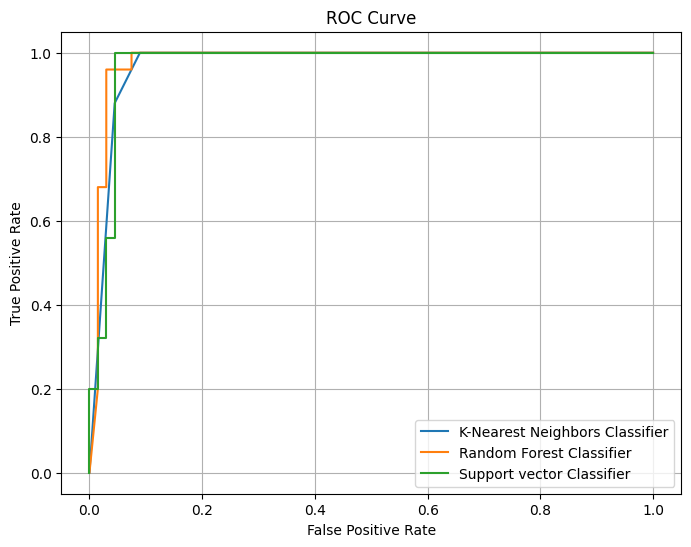

In [ ]:
knn_fs_auc_roc = evaluate_roc_auc(fs_KNN, X_test, y_test)

# Print the results
print("K-Nearest Neighbors Classifier AUC-ROC:", knn_fs_auc_roc)
print("Random Forest Classifier AUC-ROC:", rf_auc_roc)
print("Support vector Classifier AUC-ROC:", svc_auc_roc)

# Plot ROC curve for both models

plt.figure(figsize=(8, 6))
plot_roc_curve(fs_KNN, X_test, y_test_binary, 'K-Nearest Neighbors Classifier')
plot_roc_curve(rf_model, X_test, y_test_binary, 'Random Forest Classifier')
plot_roc_curve(svc_model, X_test, y_test_binary, 'Support vector Classifier')
plt.show()

The more accurate classifier for this problem is the RF:
- previous ROC score was 0.983, now is 0.991 (so better fit)

Followed by the KNN:
- previous ROC score was 0.954, now is 0.987 (so better fit)

Finally by the SVC:
- previous ROC score was 0.973, now is 0.984 (so better fit)

# Visualization of the random tree decisions

Now that we have seen that RF is the best classifier, we would like to see if we can extract interesting information from the decision mechanisms that it uses.

In [ ]:
best_trees = rf_parameter[0]

However, as many trees are created using random selection of the features to split, we haven't a way to see a good tree partition.

In [ ]:

# Define your feature and target names
feature_names = rf_features_names

target_names = ["Autistic", "Control"]  # Adjust according to your target classes

In [ ]:
transformer = rf_model.named_steps['preprocessor']
X_test_transformed = transformer.transform(X_test)
X_train_transformed = transformer.transform(X_train)

X_test_transformed_df = pd.DataFrame(X_test_transformed, columns=transformer.get_feature_names_out())
X_test_transformed = X_test_transformed_df[feature_names]
X_train_transformed_df = pd.DataFrame(X_train_transformed, columns=transformer.get_feature_names_out())
X_train_transformed = X_train_transformed_df[feature_names]

# Access the random forest classifier from the pipeline
rf = rf_model.named_steps['classifier']

accuracies = []
for i, tree in enumerate(rf.estimators_):
    # Make predictions with the individual tree
    y_pred = tree.predict(X_test_transformed.values)
    # Calculate the accuracy
    accuracy = accuracy_score(y_test, y_pred)
    accuracies.append((i, accuracy))

# Find the tree with the highest accuracy
most_accurate_tree_index, highest_accuracy = max(accuracies, key=lambda x: x[1])
most_accurate_tree = rf.estimators_[most_accurate_tree_index]

print(f"The most accurate tree is tree number {most_accurate_tree_index} with accuracy of {highest_accuracy:.2f}")


The most accurate tree is tree number 22 with accuracy of 0.15


In this case we saw that the tree that better classify the test data has a accuracy of only 0.11. So it's not reliable to learn rules from there.

However, we will show it, to have an idea of the splits.

In [ ]:
# Export one of the trees from the forest
tree = rf.estimators_[most_accurate_tree_index]

# Plot the tree
plt.figure(figsize=(200,100))
plot_tree(most_accurate_tree, feature_names=feature_names, class_names=target_names, filled=True, rounded=True, fontsize=12)
plt.show()

MemoryError: In RendererAgg: Out of memory

Error in callback <function _draw_all_if_interactive at 0x000001E46AE02CB0> (for post_execute):


MemoryError: In RendererAgg: Out of memory

MemoryError: In RendererAgg: Out of memory

<Figure size 20000x10000 with 1 Axes>

However, the accuracy of the tree is not good, so this splits are thresholds are not reliables.

Another usefull insight can be achieved seeing the feature importance.

In [ ]:
# Feature importances
importances = rf.feature_importances_
indices = np.argsort(importances)[::-1]


# Print feature ranking
print("Feature ranking:")
for f in range((X_train_transformed.shape[1])):
    print(f"{f + 1}. feature {indices[f]} : {feature_names[f]} ({importances[indices[f]]})")

# Plot the feature importances of the forest
plt.figure()
plt.title("Feature importances")
plt.bar(range(X_train_transformed.shape[1]), importances[indices], color="r", align="center")
plt.xticks(range(X_train_transformed.shape[1]), X_train_transformed.columns[indices], rotation=90)
plt.xlim([-1, X_train_transformed.shape[1]])
plt.show()


We can see that the more relevant feature for the decision is ADI_R_VERBAL_TOTAL_BV, followed by ADOS_TOTAL. This outcome seems to be meaningfull due to the fact that this two feature are the only one that are really created to account autism. But we can't overcome the fact that they are also the ones that has the biggest quantity of missing values, so we have to be carefull with the analysis of this results.

# Comparison with Literature

We upload the dataset gave by the authors which has no presence of missing values and has been treated with feature selection

In [ ]:
ASD_phenotypic_literature = pd.read_csv(os.path.join('DataSets','Phenotypic Datasets','ASD_phenotypic_paper.csv'))

In [ ]:
ASD_phenotypic_literature.info()

We drop the columns that we don't need and separate data for the diagnosis database.

In [ ]:
ASD_clinical_lit = ASD_phenotypic_literature[['DX_GROUP']]
# Drop  columns DX_GROUP and storage it apart 
ASD_phenotypic_lit = ASD_phenotypic_literature.drop(columns=['DX_GROUP', 'DSM_IV_TR', 'Unnamed: 0.1', 'Unnamed: 0', 'SUB_ID', 'X', 'subject', 'SITE_ID', 'FILE_ID', 'EYE_STATUS_AT_SCAN'])

In [ ]:
ASD_phenotypic_lit.info()

In [ ]:
ASD_clinical_lit.info()

Now we split the dataset and apply SMOTE

In [ ]:
X_train_lit, X_test_lit, y_train_lit, y_test_lit = train_test_split(ASD_phenotypic_lit, ASD_clinical_lit['DX_GROUP'], test_size=0.3, random_state=42)

# Initialize the SMOTE-NC object
sampler = SMOTE(random_state=42)
X_SMOTE_lit, Y_SMOTE_lit = sampler.fit_resample(X_train_lit, y_train_lit)

Now we are ready to perform the Random Forest Classifier on the dataset.

In [ ]:
classifier = RandomForestClassifier(random_state=42)
rf_model_lit, rf_parameter_lit, rf_scores_lit, _ = general_pipeline(X_SMOTE_lit, Y_SMOTE_lit, classifier,  parameters_grid_search = rf_parameter)

Now we fit on the test to see the final accuracy and f1_score

In [ ]:
y_pred = rf_model_lit.predict(X_test_lit)

# Prints and stores scores of the model on testing set
accuracy, precision, recall, f1 = of.evaluation_test_scores(y_test_lit, y_pred)